### Inference notebook:
- https://www.kaggle.com/code/ravaghi/skin-cancer-detection-resnet50-inference

# Imports and configs

In [1]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_curve, auc
from torch.utils.data import DataLoader, Dataset
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import albumentations as A
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import torch.nn as nn
import pandas as pd
import numpy as np
import warnings
import h5py
import torch
import random
import timm
import io
import os
import gc

warnings.filterwarnings('ignore')

In [2]:
class CFG:
    train_metadata_path = '/kaggle/input/isic-2024-challenge/train-metadata.csv'
    test_metadata_path = '/kaggle/input/isic-2024-challenge/test-metadata.csv'
    train_img_path = '/kaggle/input/isic-2024-challenge/train-image.hdf5'
    test_img_path = '/kaggle/input/isic-2024-challenge/test-image.hdf5'
    sample_sub_path = '/kaggle/input/isic-2024-challenge/sample_submission.csv'
    checkpoint_path = '/kaggle/working/checkpoints'

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    max_epochs = 50
    learning_rate = 1e-4
    train_batch_size = 32
    val_batch_size = 64
    n_folds = 5
    seed = 35555
    model_name = "resnet50"
    es_patience = 10

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG.seed)

# Loading and splitting the datasets

In [4]:
train_metadata = pd.read_csv(CFG.train_metadata_path)

positives = train_metadata[train_metadata.target == 1]
negatives = train_metadata[train_metadata.target == 0]
train_metadata = pd.concat([positives, negatives.sample(n=20 * len(positives), random_state=CFG.seed)])
train_metadata = train_metadata.sample(frac=1, random_state=CFG.seed).reset_index(drop=True)

In [5]:
sgkf = StratifiedGroupKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
split = sgkf.split(train_metadata, train_metadata.target, groups=train_metadata.patient_id)
for i, (_, val_index) in enumerate(split):
    train_metadata.loc[val_index, 'fold'] = i

In [6]:
train_metadata2 = pd.read_csv(CFG.train_metadata_path)

sgkf = StratifiedGroupKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
split = sgkf.split(train_metadata2, train_metadata2.target, groups=train_metadata2.patient_id)
for i, (_, val_index) in enumerate(split):
    train_metadata2.loc[val_index, 'fold'] = i

# Creating a custom image dataset

In [7]:
class ISICDataset(Dataset):
    def __init__(self, data_path, metadata, transform=None):
        self.data = h5py.File(data_path, 'r')
        self.metadata = metadata
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_name = self.metadata.iloc[idx]['isic_id']
        image = np.array(self.data[img_name])
        image = np.array(Image.open(io.BytesIO(image)), dtype=np.float32)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        if 'target' in self.metadata.columns:
            label = int(self.metadata['target'].iloc[idx])
            return image, label
        else:
            return image, 0

In [8]:
# Reference: https://www.kaggle.com/code/motono0223/isic-pytorch-training-baseline-image-only

transforms = {
    "train": A.Compose([
        A.Resize(224, 224),
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Downscale(p=0.25),
        A.ShiftScaleRotate(
            shift_limit=0.1,
            scale_limit=0.15,
            rotate_limit=60,
            p=0.5
        ),
        A.HueSaturationValue(
            hue_shift_limit=0.2,
            sat_shift_limit=0.2,
            val_shift_limit=0.2,
            p=0.5
        ),
        A.RandomBrightnessContrast(
            brightness_limit=(-0.1, 0.1),
            contrast_limit=(-0.1, 0.1),
            p=0.5
        ),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0,
            p=1.0
        ),
        ToTensorV2()], p=1.),

    "val": A.Compose([
        A.Resize(224, 224),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0,
            p=1.0
        ),
        ToTensorV2()], p=1.)
}

# Customizing the image model

In [9]:
class ResNet50(nn.Module):
    def __init__(self, model_name, num_classes=2, pretrained=True):
        super(ResNet50, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=3)
        self.model.reset_classifier(num_classes=num_classes, global_pool='avg')

    def forward(self, x):
        return self.model(x)

# Creating a trainer class

In [10]:
class Trainer:
    def __init__(
        self,
        device,
        model,
        criterion,
        optimizer,
        scheduler,
        train_dataloader,
        val_dataloader,
        checkpoint_path,
        fold_idx,
        es_patience
    ):
        self.device = device
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.checkpoint_path = checkpoint_path
        self.best_pauc = 0.0
        self.best_model_path = None
        self.fold_idx = fold_idx
        self.es_patience = es_patience
        self.create_checkpoint_path()

    def create_checkpoint_path(self):
        if not os.path.exists(self.checkpoint_path):
            os.makedirs(self.checkpoint_path)

    @staticmethod
    def p_roc_auc_score(y_true, y_preds, min_tpr: float = 0.80):
        v_gt = abs(np.asarray(y_true)-1)
        v_pred = -1.0 * np.asarray(y_preds)
        max_fpr = abs(1-min_tpr)
        fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
        if max_fpr is None or max_fpr == 1:
            return auc(fpr, tpr)
        if max_fpr <= 0 or max_fpr > 1:
            raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
        stop = np.searchsorted(fpr, max_fpr, "right")
        x_interp = [fpr[stop - 1], fpr[stop]]
        y_interp = [tpr[stop - 1], tpr[stop]]
        tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
        fpr = np.append(fpr[:stop], max_fpr)
        partial_auc = auc(fpr, tpr)
        return partial_auc

    def train(self, current_epoch_nr):
        self.model.train()

        num_batches = len(self.train_dataloader)

        running_loss = 0.0
        total = 0

        preds = []
        targets = []

        loop = tqdm(self.train_dataloader, total=num_batches)
        for batch in loop:
            x, y = batch
            x, y = x.to(self.device), y.to(self.device)

            self.optimizer.zero_grad()

            y_hat = self.model(x)
            pred_probs = F.softmax(y_hat, dim=1)

            preds.extend(pred_probs[:, 1].detach().cpu().numpy())
            targets.extend(y.detach().cpu().numpy())

            loss = self.criterion(y_hat, y)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * x.size(0)
            total += y.size(0)

            loop.set_description(f'Epoch {current_epoch_nr}')
            loop.set_postfix(train_loss=round(running_loss / total, 6))

            if self.scheduler is not None:
                self.scheduler.step()

        train_pauc = self.p_roc_auc_score(targets, preds)
        train_loss = running_loss / num_batches

        return train_pauc, train_loss

    def evaluate(self, current_epoch_nr):
        self.model.eval()

        num_batches = len(self.val_dataloader)

        running_loss = 0.0
        total = 0

        preds = []
        targets = []

        with torch.no_grad():
            loop = tqdm(self.val_dataloader, total=num_batches)
            for batch in loop:
                x, y = batch
                x, y = x.to(self.device), y.to(self.device)

                self.optimizer.zero_grad()

                y_hat = self.model(x)
                pred_probs = F.softmax(y_hat, dim=1)

                preds.extend(pred_probs[:, 1].detach().cpu().numpy())
                targets.extend(y.detach().cpu().numpy())

                loss = self.criterion(y_hat, y)
                running_loss += loss.item() * x.size(0)
                total += y.size(0)

                loop.set_description(f'Epoch {current_epoch_nr}')
                loop.set_postfix(val_loss=round(running_loss / total, 6))

        val_pauc = self.p_roc_auc_score(targets, preds)
        val_loss = running_loss / num_batches

        if val_pauc > self.best_pauc:
            self.es_patience = CFG.es_patience
            if self.best_pauc != 0.0:
                print(f'New best model found: pAUC = {val_pauc:.6f} (previous best: {self.best_pauc:.6f})')
            self.best_pauc = val_pauc
            checkpoint_name = f'fold_{self.fold_idx}_epoch_{current_epoch_nr}_pauc_{round(val_pauc, 6)}.pth'

            for file in os.listdir(self.checkpoint_path):
                if file.startswith(f'fold_{self.fold_idx}_epoch_'):
                    os.remove(os.path.join(self.checkpoint_path, file))

            torch.save(
                self.model.state_dict(),
                os.path.join(self.checkpoint_path, checkpoint_name)
            )
            self.best_model_path = os.path.join(
                self.checkpoint_path, checkpoint_name)

        else:
            self.es_patience -= 1
            if self.es_patience == 0:
                print(f'Early stopping triggered at epoch {current_epoch_nr}. Best pAUC = {self.best_pauc:.6f}')
                return val_pauc, val_loss, True

        return val_pauc, val_loss, False

    def predict(self, dataloader):
        model = self.model.to(self.device)
        model.load_state_dict(torch.load(self.best_model_path))
        model.eval()

        preds = []
        with torch.no_grad():
            loop = tqdm(dataloader, total=len(dataloader))
            for batch in loop:
                x, _ = batch
                x = x.to(self.device)
                y_hat = model(x)
                pred_probs = F.softmax(y_hat, dim=1)
                preds.extend(pred_probs.detach().cpu().numpy())
                loop.set_description(f'Prediction')

        return preds

# Training and cross-validation

In [11]:
histories = {}
oof_pred_probs_df = []

for fold_idx in range(CFG.n_folds):
    print(f'---------------------------------- Fold {fold_idx + 1} ----------------------------------')

    _train = train_metadata[train_metadata['fold'] != fold_idx]
    train_dataset = ISICDataset(CFG.train_img_path, _train, transforms['train'])
    train_dataloader = DataLoader(train_dataset, batch_size=CFG.train_batch_size, shuffle=True,  num_workers=4)

    _val = train_metadata[train_metadata['fold'] == fold_idx]
    val_dataset = ISICDataset(CFG.train_img_path, _val, transforms['val'])
    val_dataloader = DataLoader(val_dataset, batch_size=CFG.val_batch_size, shuffle=False, num_workers=4)

    _val2 = train_metadata2[train_metadata2['fold'] == fold_idx]
    val_dataset2 = ISICDataset(CFG.train_img_path, _val2, transforms['val'])
    val_dataloader2 = DataLoader(val_dataset2, batch_size=CFG.val_batch_size, shuffle=False, num_workers=4)

    model = ResNet50(CFG.model_name).to(CFG.device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=CFG.learning_rate)
    t_max = len(train_dataloader) * CFG.max_epochs
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=t_max, eta_min=1e-6)

    trainer = Trainer(
        device=CFG.device,
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        checkpoint_path=CFG.checkpoint_path,
        fold_idx=fold_idx,
        es_patience=CFG.es_patience
    )

    history = {
        'epoch': [],
        'train_pauc': [],
        'train_loss': [],
        'val_pauc': [],
        'val_loss': []
    }
    for epoch in range(1, CFG.max_epochs + 1):
        train_pauc, train_loss = trainer.train(current_epoch_nr=epoch)
        val_pauc, val_loss, es_triggered = trainer.evaluate(current_epoch_nr=epoch)

        print(f"Epoch {epoch}: Train pAUC: {train_pauc:.6f} - Val pAUC: {val_pauc:.6f} | Train Loss: {train_loss:.6f} - Val Loss: {val_loss:.6f}\n")

        history['epoch'].append(epoch)
        history['train_pauc'].append(train_pauc)
        history['train_loss'].append(train_loss)
        history['val_pauc'].append(val_pauc)
        history['val_loss'].append(val_loss)

        if es_triggered:
            break

    histories[f'Fold {fold_idx + 1}'] = history

    pred_probs = trainer.predict(val_dataloader2)
    cols = ['p0', 'p1']
    _val2[cols] = pred_probs
    oof_pred_probs_df.append(_val2)

    del _train, _val, train_dataset, val_dataset, model, criterion, optimizer, scheduler, trainer
    gc.collect()
    torch.cuda.empty_cache()

    print(f'---------------------------------- Fold {fold_idx + 1} ----------------------------------\n\n')

---------------------------------- Fold 1 ----------------------------------


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Epoch 1: 100%|██████████| 25/25 [00:03<00:00,  6.77it/s, val_loss=0.168]


Epoch 1: Train pAUC: 0.022008 - Val pAUC: 0.029528 | Train Loss: 7.763242 - Val Loss: 10.698905



Epoch 2: 100%|██████████| 25/25 [00:03<00:00,  7.40it/s, val_loss=0.162]


New best model found: pAUC = 0.047828 (previous best: 0.029528)
Epoch 2: Train pAUC: 0.026744 - Val pAUC: 0.047828 | Train Loss: 6.249670 - Val Loss: 10.332029



Epoch 3: 100%|██████████| 25/25 [00:03<00:00,  7.35it/s, val_loss=0.161]


New best model found: pAUC = 0.062941 (previous best: 0.047828)
Epoch 3: Train pAUC: 0.030094 - Val pAUC: 0.062941 | Train Loss: 6.201594 - Val Loss: 10.238343



Epoch 4: 100%|██████████| 25/25 [00:03<00:00,  7.37it/s, val_loss=0.151]


Epoch 4: Train pAUC: 0.050102 - Val pAUC: 0.055455 | Train Loss: 5.918973 - Val Loss: 9.634905



Epoch 5: 100%|██████████| 25/25 [00:03<00:00,  7.28it/s, val_loss=0.158]


New best model found: pAUC = 0.065291 (previous best: 0.062941)
Epoch 5: Train pAUC: 0.065630 - Val pAUC: 0.065291 | Train Loss: 5.538768 - Val Loss: 10.066680



Epoch 6: 100%|██████████| 25/25 [00:03<00:00,  7.46it/s, val_loss=0.146]


New best model found: pAUC = 0.069246 (previous best: 0.065291)
Epoch 6: Train pAUC: 0.060898 - Val pAUC: 0.069246 | Train Loss: 5.525241 - Val Loss: 9.279743



Epoch 7: 100%|██████████| 25/25 [00:03<00:00,  7.46it/s, val_loss=0.151]


Epoch 7: Train pAUC: 0.059958 - Val pAUC: 0.064938 | Train Loss: 5.551812 - Val Loss: 9.591415



Epoch 8: 100%|██████████| 25/25 [00:03<00:00,  7.37it/s, val_loss=0.143]


New best model found: pAUC = 0.072333 (previous best: 0.069246)
Epoch 8: Train pAUC: 0.070827 - Val pAUC: 0.072333 | Train Loss: 5.301683 - Val Loss: 9.077581



Epoch 9: 100%|██████████| 25/25 [00:03<00:00,  7.43it/s, val_loss=0.135]


New best model found: pAUC = 0.072353 (previous best: 0.072333)
Epoch 9: Train pAUC: 0.082731 - Val pAUC: 0.072353 | Train Loss: 5.295858 - Val Loss: 8.587551



Epoch 10: 100%|██████████| 25/25 [00:03<00:00,  7.15it/s, val_loss=0.148]


Epoch 10: Train pAUC: 0.072914 - Val pAUC: 0.063536 | Train Loss: 5.225863 - Val Loss: 9.384813



Epoch 11: 100%|██████████| 25/25 [00:03<00:00,  7.39it/s, val_loss=0.154]


Epoch 11: Train pAUC: 0.078353 - Val pAUC: 0.070265 | Train Loss: 5.114578 - Val Loss: 9.816151



Epoch 12: 100%|██████████| 25/25 [00:03<00:00,  7.52it/s, val_loss=0.152]


Epoch 12: Train pAUC: 0.085034 - Val pAUC: 0.066451 | Train Loss: 5.055805 - Val Loss: 9.666915



Epoch 13: 100%|██████████| 25/25 [00:03<00:00,  7.40it/s, val_loss=0.15]


Epoch 13: Train pAUC: 0.078677 - Val pAUC: 0.063122 | Train Loss: 5.224875 - Val Loss: 9.527437



Epoch 14: 100%|██████████| 25/25 [00:03<00:00,  7.26it/s, val_loss=0.137]


New best model found: pAUC = 0.086255 (previous best: 0.072353)
Epoch 14: Train pAUC: 0.085682 - Val pAUC: 0.086255 | Train Loss: 5.002964 - Val Loss: 8.686573



Epoch 15: 100%|██████████| 25/25 [00:03<00:00,  7.29it/s, val_loss=0.13]


New best model found: pAUC = 0.086608 (previous best: 0.086255)
Epoch 15: Train pAUC: 0.091729 - Val pAUC: 0.086608 | Train Loss: 4.859760 - Val Loss: 8.249038



Epoch 16: 100%|██████████| 25/25 [00:03<00:00,  7.28it/s, val_loss=0.144]


Epoch 16: Train pAUC: 0.080996 - Val pAUC: 0.081201 | Train Loss: 5.017016 - Val Loss: 9.168263



Epoch 17: 100%|██████████| 25/25 [00:03<00:00,  7.19it/s, val_loss=0.137]


New best model found: pAUC = 0.092106 (previous best: 0.086608)
Epoch 17: Train pAUC: 0.086000 - Val pAUC: 0.092106 | Train Loss: 4.928026 - Val Loss: 8.700130



Epoch 18: 100%|██████████| 25/25 [00:03<00:00,  7.30it/s, val_loss=0.138]


Epoch 18: Train pAUC: 0.089162 - Val pAUC: 0.082361 | Train Loss: 4.782991 - Val Loss: 8.750450



Epoch 19: 100%|██████████| 25/25 [00:03<00:00,  7.30it/s, val_loss=0.143]


Epoch 19: Train pAUC: 0.095148 - Val pAUC: 0.086578 | Train Loss: 4.779680 - Val Loss: 9.117110



Epoch 20: 100%|██████████| 25/25 [00:03<00:00,  7.25it/s, val_loss=0.164]


New best model found: pAUC = 0.101871 (previous best: 0.092106)
Epoch 20: Train pAUC: 0.088986 - Val pAUC: 0.101871 | Train Loss: 4.803114 - Val Loss: 10.440059



Epoch 21: 100%|██████████| 25/25 [00:03<00:00,  7.35it/s, val_loss=0.131]


Epoch 21: Train pAUC: 0.094114 - Val pAUC: 0.096918 | Train Loss: 4.704720 - Val Loss: 8.322789



Epoch 22: 100%|██████████| 25/25 [00:03<00:00,  7.16it/s, val_loss=0.139]


Epoch 22: Train pAUC: 0.081932 - Val pAUC: 0.080706 | Train Loss: 4.866446 - Val Loss: 8.819071



Epoch 23: 100%|██████████| 25/25 [00:03<00:00,  7.36it/s, val_loss=0.132]


Epoch 23: Train pAUC: 0.092780 - Val pAUC: 0.097261 | Train Loss: 4.827883 - Val Loss: 8.393734



Epoch 24: 100%|██████████| 25/25 [00:03<00:00,  7.39it/s, val_loss=0.133]


Epoch 24: Train pAUC: 0.093055 - Val pAUC: 0.092741 | Train Loss: 4.812542 - Val Loss: 8.431140



Epoch 25: 100%|██████████| 25/25 [00:03<00:00,  7.20it/s, val_loss=0.149]


Epoch 25: Train pAUC: 0.095265 - Val pAUC: 0.081019 | Train Loss: 4.703785 - Val Loss: 9.460194



Epoch 26: 100%|██████████| 25/25 [00:03<00:00,  7.43it/s, val_loss=0.136]


Epoch 26: Train pAUC: 0.098497 - Val pAUC: 0.093407 | Train Loss: 4.616134 - Val Loss: 8.630754



Epoch 27: 100%|██████████| 25/25 [00:03<00:00,  7.38it/s, val_loss=0.135]


Epoch 27: Train pAUC: 0.093833 - Val pAUC: 0.082583 | Train Loss: 4.710534 - Val Loss: 8.598554



Epoch 28: 100%|██████████| 25/25 [00:03<00:00,  7.23it/s, val_loss=0.136]


Epoch 28: Train pAUC: 0.089629 - Val pAUC: 0.078931 | Train Loss: 4.759837 - Val Loss: 8.646253



Epoch 29: 100%|██████████| 25/25 [00:03<00:00,  7.31it/s, val_loss=0.134]


Epoch 29: Train pAUC: 0.094991 - Val pAUC: 0.084419 | Train Loss: 4.615564 - Val Loss: 8.503216



Epoch 30: 100%|██████████| 25/25 [00:03<00:00,  7.26it/s, val_loss=0.131]


Early stopping triggered at epoch 30. Best pAUC = 0.101871
Epoch 30: Train pAUC: 0.094809 - Val pAUC: 0.081544 | Train Loss: 4.529262 - Val Loss: 8.360148



Prediction: 100%|██████████| 1211/1211 [02:18<00:00,  8.73it/s]


---------------------------------- Fold 1 ----------------------------------


---------------------------------- Fold 2 ----------------------------------


Epoch 1: 100%|██████████| 29/29 [00:03<00:00,  7.55it/s, val_loss=0.161]


Epoch 1: Train pAUC: 0.026886 - Val pAUC: 0.055624 | Train Loss: 7.857931 - Val Loss: 10.130006



Epoch 2: 100%|██████████| 29/29 [00:03<00:00,  7.53it/s, val_loss=0.167]


Epoch 2: Train pAUC: 0.034606 - Val pAUC: 0.037403 | Train Loss: 6.399959 - Val Loss: 10.504891



Epoch 3: 100%|██████████| 29/29 [00:03<00:00,  7.48it/s, val_loss=0.144]


New best model found: pAUC = 0.076261 (previous best: 0.055624)
Epoch 3: Train pAUC: 0.039130 - Val pAUC: 0.076261 | Train Loss: 6.121019 - Val Loss: 9.098647



Epoch 4: 100%|██████████| 29/29 [00:04<00:00,  7.12it/s, val_loss=0.133]


New best model found: pAUC = 0.083385 (previous best: 0.076261)
Epoch 4: Train pAUC: 0.044962 - Val pAUC: 0.083385 | Train Loss: 6.003269 - Val Loss: 8.355353



Epoch 5: 100%|██████████| 29/29 [00:04<00:00,  6.93it/s, val_loss=0.123]


New best model found: pAUC = 0.106889 (previous best: 0.083385)
Epoch 5: Train pAUC: 0.055580 - Val pAUC: 0.106889 | Train Loss: 5.745895 - Val Loss: 7.775718



Epoch 6: 100%|██████████| 29/29 [00:03<00:00,  7.31it/s, val_loss=0.127]


Epoch 6: Train pAUC: 0.061747 - Val pAUC: 0.087057 | Train Loss: 5.735954 - Val Loss: 7.974105



Epoch 7: 100%|██████████| 29/29 [00:03<00:00,  7.26it/s, val_loss=0.132]


Epoch 7: Train pAUC: 0.050965 - Val pAUC: 0.103897 | Train Loss: 5.589538 - Val Loss: 8.351236



Epoch 8: 100%|██████████| 29/29 [00:03<00:00,  7.33it/s, val_loss=0.121]


Epoch 8: Train pAUC: 0.062004 - Val pAUC: 0.098262 | Train Loss: 5.493869 - Val Loss: 7.612808



Epoch 9: 100%|██████████| 29/29 [00:03<00:00,  7.43it/s, val_loss=0.116]


New best model found: pAUC = 0.110236 (previous best: 0.106889)
Epoch 9: Train pAUC: 0.064248 - Val pAUC: 0.110236 | Train Loss: 5.503306 - Val Loss: 7.315844



Epoch 10: 100%|██████████| 29/29 [00:03<00:00,  7.44it/s, val_loss=0.136]


New best model found: pAUC = 0.130784 (previous best: 0.110236)
Epoch 10: Train pAUC: 0.082346 - Val pAUC: 0.130784 | Train Loss: 5.153182 - Val Loss: 8.601704



Epoch 11: 100%|██████████| 29/29 [00:03<00:00,  7.56it/s, val_loss=0.117]


Epoch 11: Train pAUC: 0.073205 - Val pAUC: 0.098565 | Train Loss: 5.379664 - Val Loss: 7.400924



Epoch 12: 100%|██████████| 29/29 [00:03<00:00,  7.47it/s, val_loss=0.111]


New best model found: pAUC = 0.137237 (previous best: 0.130784)
Epoch 12: Train pAUC: 0.084161 - Val pAUC: 0.137237 | Train Loss: 5.132183 - Val Loss: 7.021449



Epoch 13: 100%|██████████| 29/29 [00:03<00:00,  7.47it/s, val_loss=0.117]


Epoch 13: Train pAUC: 0.080558 - Val pAUC: 0.130007 | Train Loss: 5.201625 - Val Loss: 7.352920



Epoch 14: 100%|██████████| 29/29 [00:03<00:00,  7.43it/s, val_loss=0.109]


Epoch 14: Train pAUC: 0.066133 - Val pAUC: 0.131002 | Train Loss: 5.355933 - Val Loss: 6.888454



Epoch 15: 100%|██████████| 29/29 [00:03<00:00,  7.56it/s, val_loss=0.11]


Epoch 15: Train pAUC: 0.074636 - Val pAUC: 0.132414 | Train Loss: 5.317452 - Val Loss: 6.958937



Epoch 16: 100%|██████████| 29/29 [00:03<00:00,  7.53it/s, val_loss=0.115]


Epoch 16: Train pAUC: 0.081677 - Val pAUC: 0.108509 | Train Loss: 5.084194 - Val Loss: 7.226337



Epoch 17: 100%|██████████| 29/29 [00:03<00:00,  7.50it/s, val_loss=0.116]


New best model found: pAUC = 0.139568 (previous best: 0.137237)
Epoch 17: Train pAUC: 0.079481 - Val pAUC: 0.139568 | Train Loss: 5.116001 - Val Loss: 7.312271



Epoch 18: 100%|██████████| 29/29 [00:03<00:00,  7.58it/s, val_loss=0.109]


Epoch 18: Train pAUC: 0.085728 - Val pAUC: 0.137750 | Train Loss: 5.048643 - Val Loss: 6.866408



Epoch 19: 100%|██████████| 29/29 [00:03<00:00,  7.49it/s, val_loss=0.106]


Epoch 19: Train pAUC: 0.088564 - Val pAUC: 0.134315 | Train Loss: 5.038508 - Val Loss: 6.672865



Epoch 20: 100%|██████████| 29/29 [00:03<00:00,  7.60it/s, val_loss=0.11]


Epoch 20: Train pAUC: 0.083457 - Val pAUC: 0.125386 | Train Loss: 5.011297 - Val Loss: 6.914997



Epoch 21: 100%|██████████| 29/29 [00:03<00:00,  7.56it/s, val_loss=0.114]


Epoch 21: Train pAUC: 0.082822 - Val pAUC: 0.135282 | Train Loss: 5.100728 - Val Loss: 7.163593



Epoch 22: 100%|██████████| 29/29 [00:03<00:00,  7.54it/s, val_loss=0.117]


Epoch 22: Train pAUC: 0.091470 - Val pAUC: 0.133471 | Train Loss: 4.990090 - Val Loss: 7.381636



Epoch 23: 100%|██████████| 29/29 [00:03<00:00,  7.53it/s, val_loss=0.109]


Epoch 23: Train pAUC: 0.083113 - Val pAUC: 0.134033 | Train Loss: 5.053798 - Val Loss: 6.888806



Epoch 24: 100%|██████████| 29/29 [00:03<00:00,  7.51it/s, val_loss=0.103]


Epoch 24: Train pAUC: 0.088414 - Val pAUC: 0.137118 | Train Loss: 5.046437 - Val Loss: 6.509316



Epoch 25: 100%|██████████| 29/29 [00:03<00:00,  7.41it/s, val_loss=0.106]


Epoch 25: Train pAUC: 0.090535 - Val pAUC: 0.128901 | Train Loss: 4.946501 - Val Loss: 6.683941



Epoch 26: 100%|██████████| 29/29 [00:03<00:00,  7.44it/s, val_loss=0.116]


Epoch 26: Train pAUC: 0.075805 - Val pAUC: 0.134602 | Train Loss: 5.090531 - Val Loss: 7.309753



Epoch 27: 100%|██████████| 29/29 [00:03<00:00,  7.56it/s, val_loss=0.102]


New best model found: pAUC = 0.143621 (previous best: 0.139568)
Epoch 27: Train pAUC: 0.089621 - Val pAUC: 0.143621 | Train Loss: 4.998450 - Val Loss: 6.447698



Epoch 28: 100%|██████████| 29/29 [00:03<00:00,  7.56it/s, val_loss=0.101]


Epoch 28: Train pAUC: 0.078824 - Val pAUC: 0.139448 | Train Loss: 5.011683 - Val Loss: 6.341943



Epoch 29: 100%|██████████| 29/29 [00:03<00:00,  7.52it/s, val_loss=0.0964]


Epoch 29: Train pAUC: 0.092855 - Val pAUC: 0.141846 | Train Loss: 4.852069 - Val Loss: 6.074528



Epoch 30: 100%|██████████| 29/29 [00:03<00:00,  7.53it/s, val_loss=0.1]


Epoch 30: Train pAUC: 0.090415 - Val pAUC: 0.141060 | Train Loss: 4.988363 - Val Loss: 6.302254



Epoch 31: 100%|██████████| 29/29 [00:03<00:00,  7.58it/s, val_loss=0.0962]


New best model found: pAUC = 0.145037 (previous best: 0.143621)
Epoch 31: Train pAUC: 0.096536 - Val pAUC: 0.145037 | Train Loss: 4.884501 - Val Loss: 6.061394



Epoch 32: 100%|██████████| 29/29 [00:03<00:00,  7.29it/s, val_loss=0.1]


Epoch 32: Train pAUC: 0.102285 - Val pAUC: 0.140283 | Train Loss: 4.819832 - Val Loss: 6.302291



Epoch 33: 100%|██████████| 29/29 [00:03<00:00,  7.39it/s, val_loss=0.103]


Epoch 33: Train pAUC: 0.102375 - Val pAUC: 0.135665 | Train Loss: 4.867030 - Val Loss: 6.496496



Epoch 34: 100%|██████████| 29/29 [00:03<00:00,  7.48it/s, val_loss=0.103]


Epoch 34: Train pAUC: 0.094389 - Val pAUC: 0.140596 | Train Loss: 4.927490 - Val Loss: 6.468168



Epoch 35: 100%|██████████| 29/29 [00:03<00:00,  7.54it/s, val_loss=0.0971]


Epoch 35: Train pAUC: 0.090552 - Val pAUC: 0.142746 | Train Loss: 4.924880 - Val Loss: 6.121404



Epoch 36: 100%|██████████| 29/29 [00:03<00:00,  7.44it/s, val_loss=0.0948]


New best model found: pAUC = 0.145689 (previous best: 0.145037)
Epoch 36: Train pAUC: 0.094979 - Val pAUC: 0.145689 | Train Loss: 4.860126 - Val Loss: 5.975943



Epoch 37: 100%|██████████| 29/29 [00:04<00:00,  7.18it/s, val_loss=0.0984]


New best model found: pAUC = 0.155610 (previous best: 0.145689)
Epoch 37: Train pAUC: 0.098660 - Val pAUC: 0.155610 | Train Loss: 4.759776 - Val Loss: 6.204057



Epoch 38: 100%|██████████| 29/29 [00:03<00:00,  7.33it/s, val_loss=0.0963]


Epoch 38: Train pAUC: 0.095450 - Val pAUC: 0.146821 | Train Loss: 4.820564 - Val Loss: 6.072780



Epoch 39: 100%|██████████| 29/29 [00:03<00:00,  7.47it/s, val_loss=0.096]


Epoch 39: Train pAUC: 0.101089 - Val pAUC: 0.150804 | Train Loss: 4.762498 - Val Loss: 6.051155



Epoch 40: 100%|██████████| 29/29 [00:03<00:00,  7.48it/s, val_loss=0.094]


Epoch 40: Train pAUC: 0.102018 - Val pAUC: 0.154526 | Train Loss: 4.792115 - Val Loss: 5.924979



Epoch 41: 100%|██████████| 29/29 [00:03<00:00,  7.52it/s, val_loss=0.099]


Epoch 41: Train pAUC: 0.101308 - Val pAUC: 0.149139 | Train Loss: 4.676711 - Val Loss: 6.243225



Epoch 42: 100%|██████████| 29/29 [00:03<00:00,  7.44it/s, val_loss=0.0948]


Epoch 42: Train pAUC: 0.099124 - Val pAUC: 0.147793 | Train Loss: 4.797860 - Val Loss: 5.975740



Epoch 43: 100%|██████████| 29/29 [00:03<00:00,  7.37it/s, val_loss=0.0967]


Epoch 43: Train pAUC: 0.103890 - Val pAUC: 0.143072 | Train Loss: 4.653005 - Val Loss: 6.097246



Epoch 44: 100%|██████████| 29/29 [00:03<00:00,  7.48it/s, val_loss=0.0974]


Epoch 44: Train pAUC: 0.104802 - Val pAUC: 0.142484 | Train Loss: 4.652982 - Val Loss: 6.141334



Epoch 45: 100%|██████████| 29/29 [00:03<00:00,  7.42it/s, val_loss=0.0954]


Epoch 45: Train pAUC: 0.107445 - Val pAUC: 0.144793 | Train Loss: 4.651070 - Val Loss: 6.014408



Epoch 46: 100%|██████████| 29/29 [00:03<00:00,  7.38it/s, val_loss=0.0979]


Epoch 46: Train pAUC: 0.101148 - Val pAUC: 0.140997 | Train Loss: 4.795138 - Val Loss: 6.169816



Epoch 47: 100%|██████████| 29/29 [00:03<00:00,  7.47it/s, val_loss=0.0958]


Early stopping triggered at epoch 47. Best pAUC = 0.155610
Epoch 47: Train pAUC: 0.100617 - Val pAUC: 0.151963 | Train Loss: 4.889484 - Val Loss: 6.041736



Prediction: 100%|██████████| 1310/1310 [02:32<00:00,  8.58it/s]


---------------------------------- Fold 2 ----------------------------------


---------------------------------- Fold 3 ----------------------------------


Epoch 1: 100%|██████████| 21/21 [00:02<00:00,  7.25it/s, val_loss=0.225]


Epoch 1: Train pAUC: 0.026919 - Val pAUC: 0.035180 | Train Loss: 7.724167 - Val Loss: 13.985561



Epoch 2: 100%|██████████| 21/21 [00:02<00:00,  7.22it/s, val_loss=0.192]


New best model found: pAUC = 0.042958 (previous best: 0.035180)
Epoch 2: Train pAUC: 0.025390 - Val pAUC: 0.042958 | Train Loss: 6.044238 - Val Loss: 11.920655



Epoch 3: 100%|██████████| 21/21 [00:02<00:00,  7.21it/s, val_loss=0.191]


New best model found: pAUC = 0.053825 (previous best: 0.042958)
Epoch 3: Train pAUC: 0.048104 - Val pAUC: 0.053825 | Train Loss: 5.685735 - Val Loss: 11.842504



Epoch 4: 100%|██████████| 21/21 [00:02<00:00,  7.21it/s, val_loss=0.197]


New best model found: pAUC = 0.067309 (previous best: 0.053825)
Epoch 4: Train pAUC: 0.045370 - Val pAUC: 0.067309 | Train Loss: 5.618382 - Val Loss: 12.254427



Epoch 5: 100%|██████████| 21/21 [00:02<00:00,  7.15it/s, val_loss=0.164]


New best model found: pAUC = 0.086837 (previous best: 0.067309)
Epoch 5: Train pAUC: 0.057524 - Val pAUC: 0.086837 | Train Loss: 5.370944 - Val Loss: 10.192186



Epoch 6: 100%|██████████| 21/21 [00:02<00:00,  7.09it/s, val_loss=0.169]


Epoch 6: Train pAUC: 0.056880 - Val pAUC: 0.070822 | Train Loss: 5.400781 - Val Loss: 10.499911



Epoch 7: 100%|██████████| 21/21 [00:02<00:00,  7.19it/s, val_loss=0.184]


Epoch 7: Train pAUC: 0.066889 - Val pAUC: 0.085861 | Train Loss: 5.211367 - Val Loss: 11.423273



Epoch 8: 100%|██████████| 21/21 [00:02<00:00,  7.22it/s, val_loss=0.155]


New best model found: pAUC = 0.128701 (previous best: 0.086837)
Epoch 8: Train pAUC: 0.061800 - Val pAUC: 0.128701 | Train Loss: 5.213463 - Val Loss: 9.643167



Epoch 9: 100%|██████████| 21/21 [00:02<00:00,  7.31it/s, val_loss=0.163]


Epoch 9: Train pAUC: 0.076567 - Val pAUC: 0.073559 | Train Loss: 5.092595 - Val Loss: 10.108977



Epoch 10: 100%|██████████| 21/21 [00:02<00:00,  7.28it/s, val_loss=0.15]


Epoch 10: Train pAUC: 0.069882 - Val pAUC: 0.113303 | Train Loss: 5.138382 - Val Loss: 9.335180



Epoch 11: 100%|██████████| 21/21 [00:02<00:00,  7.12it/s, val_loss=0.148]


Epoch 11: Train pAUC: 0.070695 - Val pAUC: 0.102585 | Train Loss: 5.130253 - Val Loss: 9.224972



Epoch 12: 100%|██████████| 21/21 [00:02<00:00,  7.22it/s, val_loss=0.141]


Epoch 12: Train pAUC: 0.067419 - Val pAUC: 0.114154 | Train Loss: 5.156329 - Val Loss: 8.766553



Epoch 13: 100%|██████████| 21/21 [00:02<00:00,  7.18it/s, val_loss=0.142]


Epoch 13: Train pAUC: 0.073894 - Val pAUC: 0.120826 | Train Loss: 5.045959 - Val Loss: 8.836671



Epoch 14: 100%|██████████| 21/21 [00:03<00:00,  6.73it/s, val_loss=0.146]


Epoch 14: Train pAUC: 0.077834 - Val pAUC: 0.103757 | Train Loss: 4.891979 - Val Loss: 9.078392



Epoch 15: 100%|██████████| 21/21 [00:02<00:00,  7.21it/s, val_loss=0.135]


Epoch 15: Train pAUC: 0.069114 - Val pAUC: 0.128185 | Train Loss: 5.016753 - Val Loss: 8.363194



Epoch 16: 100%|██████████| 21/21 [00:02<00:00,  7.26it/s, val_loss=0.136]


New best model found: pAUC = 0.134097 (previous best: 0.128701)
Epoch 16: Train pAUC: 0.074293 - Val pAUC: 0.134097 | Train Loss: 4.873025 - Val Loss: 8.462163



Epoch 17: 100%|██████████| 21/21 [00:02<00:00,  7.23it/s, val_loss=0.133]


New best model found: pAUC = 0.142329 (previous best: 0.134097)
Epoch 17: Train pAUC: 0.070202 - Val pAUC: 0.142329 | Train Loss: 5.000870 - Val Loss: 8.278544



Epoch 18: 100%|██████████| 21/21 [00:02<00:00,  7.32it/s, val_loss=0.16]


Epoch 18: Train pAUC: 0.082889 - Val pAUC: 0.134958 | Train Loss: 4.972437 - Val Loss: 9.964767



Epoch 19: 100%|██████████| 21/21 [00:02<00:00,  7.13it/s, val_loss=0.14]


Epoch 19: Train pAUC: 0.085119 - Val pAUC: 0.139312 | Train Loss: 4.785473 - Val Loss: 8.671303



Epoch 20: 100%|██████████| 21/21 [00:02<00:00,  7.19it/s, val_loss=0.152]


Epoch 20: Train pAUC: 0.083861 - Val pAUC: 0.111419 | Train Loss: 4.929391 - Val Loss: 9.458694



Epoch 21: 100%|██████████| 21/21 [00:02<00:00,  7.29it/s, val_loss=0.14]


Epoch 21: Train pAUC: 0.083495 - Val pAUC: 0.108543 | Train Loss: 4.651206 - Val Loss: 8.717820



Epoch 22: 100%|██████████| 21/21 [00:03<00:00,  6.78it/s, val_loss=0.137]


Epoch 22: Train pAUC: 0.092988 - Val pAUC: 0.121792 | Train Loss: 4.673764 - Val Loss: 8.486270



Epoch 23: 100%|██████████| 21/21 [00:02<00:00,  7.22it/s, val_loss=0.133]


Epoch 23: Train pAUC: 0.081213 - Val pAUC: 0.122178 | Train Loss: 4.800426 - Val Loss: 8.241944



Epoch 24: 100%|██████████| 21/21 [00:02<00:00,  7.14it/s, val_loss=0.132]


Epoch 24: Train pAUC: 0.092239 - Val pAUC: 0.124315 | Train Loss: 4.513317 - Val Loss: 8.196358



Epoch 25: 100%|██████████| 21/21 [00:02<00:00,  7.05it/s, val_loss=0.139]


Epoch 25: Train pAUC: 0.086056 - Val pAUC: 0.126868 | Train Loss: 4.758907 - Val Loss: 8.664789



Epoch 26: 100%|██████████| 21/21 [00:02<00:00,  7.21it/s, val_loss=0.14]


Epoch 26: Train pAUC: 0.090228 - Val pAUC: 0.139626 | Train Loss: 4.759382 - Val Loss: 8.728284



Epoch 27: 100%|██████████| 21/21 [00:02<00:00,  7.17it/s, val_loss=0.137]


Early stopping triggered at epoch 27. Best pAUC = 0.142329
Epoch 27: Train pAUC: 0.086598 - Val pAUC: 0.113966 | Train Loss: 4.731022 - Val Loss: 8.505972



Prediction: 100%|██████████| 1191/1191 [02:19<00:00,  8.57it/s]


---------------------------------- Fold 3 ----------------------------------


---------------------------------- Fold 4 ----------------------------------


Epoch 1: 100%|██████████| 27/27 [00:03<00:00,  7.39it/s, val_loss=0.215]


Epoch 1: Train pAUC: 0.019786 - Val pAUC: 0.023552 | Train Loss: 8.085283 - Val Loss: 13.541826



Epoch 2: 100%|██████████| 27/27 [00:03<00:00,  7.25it/s, val_loss=0.201]


New best model found: pAUC = 0.029816 (previous best: 0.023552)
Epoch 2: Train pAUC: 0.026076 - Val pAUC: 0.029816 | Train Loss: 6.255755 - Val Loss: 12.647809



Epoch 3: 100%|██████████| 27/27 [00:03<00:00,  7.35it/s, val_loss=0.16]


New best model found: pAUC = 0.068516 (previous best: 0.029816)
Epoch 3: Train pAUC: 0.031718 - Val pAUC: 0.068516 | Train Loss: 6.264500 - Val Loss: 10.098508



Epoch 4: 100%|██████████| 27/27 [00:03<00:00,  7.42it/s, val_loss=0.159]


Epoch 4: Train pAUC: 0.033042 - Val pAUC: 0.047975 | Train Loss: 6.161012 - Val Loss: 10.059852



Epoch 5: 100%|██████████| 27/27 [00:03<00:00,  7.30it/s, val_loss=0.166]


Epoch 5: Train pAUC: 0.036583 - Val pAUC: 0.057104 | Train Loss: 6.072660 - Val Loss: 10.463314



Epoch 6: 100%|██████████| 27/27 [00:03<00:00,  7.05it/s, val_loss=0.147]


New best model found: pAUC = 0.090461 (previous best: 0.068516)
Epoch 6: Train pAUC: 0.050726 - Val pAUC: 0.090461 | Train Loss: 5.839897 - Val Loss: 9.249145



Epoch 7: 100%|██████████| 27/27 [00:03<00:00,  7.49it/s, val_loss=0.157]


Epoch 7: Train pAUC: 0.062392 - Val pAUC: 0.058686 | Train Loss: 5.643883 - Val Loss: 9.879868



Epoch 8: 100%|██████████| 27/27 [00:03<00:00,  7.42it/s, val_loss=0.138]


Epoch 8: Train pAUC: 0.063271 - Val pAUC: 0.073857 | Train Loss: 5.573149 - Val Loss: 8.696722



Epoch 9: 100%|██████████| 27/27 [00:03<00:00,  7.48it/s, val_loss=0.136]


New best model found: pAUC = 0.096951 (previous best: 0.090461)
Epoch 9: Train pAUC: 0.070306 - Val pAUC: 0.096951 | Train Loss: 5.417434 - Val Loss: 8.578788



Epoch 10: 100%|██████████| 27/27 [00:03<00:00,  7.34it/s, val_loss=0.128]


Epoch 10: Train pAUC: 0.057496 - Val pAUC: 0.082170 | Train Loss: 5.430712 - Val Loss: 8.091351



Epoch 11: 100%|██████████| 27/27 [00:03<00:00,  7.43it/s, val_loss=0.136]


Epoch 11: Train pAUC: 0.072047 - Val pAUC: 0.089493 | Train Loss: 5.303160 - Val Loss: 8.556470



Epoch 12: 100%|██████████| 27/27 [00:03<00:00,  7.32it/s, val_loss=0.14]


Epoch 12: Train pAUC: 0.065165 - Val pAUC: 0.084737 | Train Loss: 5.294973 - Val Loss: 8.827374



Epoch 13: 100%|██████████| 27/27 [00:03<00:00,  7.26it/s, val_loss=0.136]


Epoch 13: Train pAUC: 0.080402 - Val pAUC: 0.076918 | Train Loss: 5.143747 - Val Loss: 8.589893



Epoch 14: 100%|██████████| 27/27 [00:03<00:00,  7.44it/s, val_loss=0.13]


Epoch 14: Train pAUC: 0.077379 - Val pAUC: 0.087196 | Train Loss: 5.020940 - Val Loss: 8.193993



Epoch 15: 100%|██████████| 27/27 [00:03<00:00,  7.49it/s, val_loss=0.127]


New best model found: pAUC = 0.125000 (previous best: 0.096951)
Epoch 15: Train pAUC: 0.075801 - Val pAUC: 0.125000 | Train Loss: 5.138090 - Val Loss: 8.035823



Epoch 16: 100%|██████████| 27/27 [00:03<00:00,  7.55it/s, val_loss=0.125]


Epoch 16: Train pAUC: 0.084412 - Val pAUC: 0.079815 | Train Loss: 5.063186 - Val Loss: 7.915679



Epoch 17: 100%|██████████| 27/27 [00:03<00:00,  6.79it/s, val_loss=0.123]


Epoch 17: Train pAUC: 0.065691 - Val pAUC: 0.109907 | Train Loss: 5.148755 - Val Loss: 7.756413



Epoch 18: 100%|██████████| 27/27 [00:03<00:00,  7.09it/s, val_loss=0.121]


Epoch 18: Train pAUC: 0.077143 - Val pAUC: 0.098663 | Train Loss: 5.113036 - Val Loss: 7.626773



Epoch 19: 100%|██████████| 27/27 [00:03<00:00,  6.98it/s, val_loss=0.122]


Epoch 19: Train pAUC: 0.080666 - Val pAUC: 0.120138 | Train Loss: 4.989146 - Val Loss: 7.691012



Epoch 20: 100%|██████████| 27/27 [00:03<00:00,  7.39it/s, val_loss=0.117]


Epoch 20: Train pAUC: 0.078490 - Val pAUC: 0.122561 | Train Loss: 5.040522 - Val Loss: 7.410978



Epoch 21: 100%|██████████| 27/27 [00:03<00:00,  7.41it/s, val_loss=0.123]


New best model found: pAUC = 0.136469 (previous best: 0.125000)
Epoch 21: Train pAUC: 0.091560 - Val pAUC: 0.136469 | Train Loss: 4.921326 - Val Loss: 7.739053



Epoch 22: 100%|██████████| 27/27 [00:03<00:00,  7.39it/s, val_loss=0.129]


Epoch 22: Train pAUC: 0.094607 - Val pAUC: 0.124974 | Train Loss: 4.739499 - Val Loss: 8.138601



Epoch 23: 100%|██████████| 27/27 [00:03<00:00,  7.47it/s, val_loss=0.118]


New best model found: pAUC = 0.138865 (previous best: 0.136469)
Epoch 23: Train pAUC: 0.090326 - Val pAUC: 0.138865 | Train Loss: 4.884827 - Val Loss: 7.420828



Epoch 24: 100%|██████████| 27/27 [00:03<00:00,  7.09it/s, val_loss=0.114]


Epoch 24: Train pAUC: 0.080743 - Val pAUC: 0.136251 | Train Loss: 4.815725 - Val Loss: 7.212600



Epoch 25: 100%|██████████| 27/27 [00:03<00:00,  7.38it/s, val_loss=0.121]


New best model found: pAUC = 0.139092 (previous best: 0.138865)
Epoch 25: Train pAUC: 0.086192 - Val pAUC: 0.139092 | Train Loss: 4.810478 - Val Loss: 7.632775



Epoch 26: 100%|██████████| 27/27 [00:03<00:00,  7.39it/s, val_loss=0.118]


Epoch 26: Train pAUC: 0.090110 - Val pAUC: 0.133626 | Train Loss: 4.785337 - Val Loss: 7.436253



Epoch 27: 100%|██████████| 27/27 [00:03<00:00,  7.41it/s, val_loss=0.114]


New best model found: pAUC = 0.141318 (previous best: 0.139092)
Epoch 27: Train pAUC: 0.091305 - Val pAUC: 0.141318 | Train Loss: 4.851243 - Val Loss: 7.173655



Epoch 28: 100%|██████████| 27/27 [00:03<00:00,  7.31it/s, val_loss=0.113]


Epoch 28: Train pAUC: 0.095569 - Val pAUC: 0.129074 | Train Loss: 4.775603 - Val Loss: 7.157088



Epoch 29: 100%|██████████| 27/27 [00:03<00:00,  7.35it/s, val_loss=0.117]


Epoch 29: Train pAUC: 0.091786 - Val pAUC: 0.124664 | Train Loss: 4.863238 - Val Loss: 7.409496



Epoch 30: 100%|██████████| 27/27 [00:03<00:00,  7.47it/s, val_loss=0.123]


Epoch 30: Train pAUC: 0.087853 - Val pAUC: 0.141052 | Train Loss: 4.826582 - Val Loss: 7.743160



Epoch 31: 100%|██████████| 27/27 [00:03<00:00,  7.39it/s, val_loss=0.113]


Epoch 31: Train pAUC: 0.099758 - Val pAUC: 0.139437 | Train Loss: 4.784093 - Val Loss: 7.155450



Epoch 32: 100%|██████████| 27/27 [00:03<00:00,  7.46it/s, val_loss=0.109]


Epoch 32: Train pAUC: 0.097278 - Val pAUC: 0.137750 | Train Loss: 4.693722 - Val Loss: 6.871392



Epoch 33: 100%|██████████| 27/27 [00:03<00:00,  7.35it/s, val_loss=0.111]


New best model found: pAUC = 0.146819 (previous best: 0.141318)
Epoch 33: Train pAUC: 0.092101 - Val pAUC: 0.146819 | Train Loss: 4.704795 - Val Loss: 6.992707



Epoch 34: 100%|██████████| 27/27 [00:03<00:00,  7.17it/s, val_loss=0.112]


Epoch 34: Train pAUC: 0.092211 - Val pAUC: 0.138022 | Train Loss: 4.776623 - Val Loss: 7.056457



Epoch 35: 100%|██████████| 27/27 [00:03<00:00,  6.96it/s, val_loss=0.112]


Epoch 35: Train pAUC: 0.100553 - Val pAUC: 0.139533 | Train Loss: 4.735036 - Val Loss: 7.033549



Epoch 36: 100%|██████████| 27/27 [00:03<00:00,  7.49it/s, val_loss=0.109]


Epoch 36: Train pAUC: 0.100178 - Val pAUC: 0.145640 | Train Loss: 4.709714 - Val Loss: 6.859674



Epoch 37: 100%|██████████| 27/27 [00:03<00:00,  7.47it/s, val_loss=0.114]


Epoch 37: Train pAUC: 0.093941 - Val pAUC: 0.142844 | Train Loss: 4.676178 - Val Loss: 7.216859



Epoch 38: 100%|██████████| 27/27 [00:03<00:00,  7.48it/s, val_loss=0.11]


Epoch 38: Train pAUC: 0.100272 - Val pAUC: 0.141612 | Train Loss: 4.715055 - Val Loss: 6.968127



Epoch 39: 100%|██████████| 27/27 [00:03<00:00,  7.31it/s, val_loss=0.107]


Epoch 39: Train pAUC: 0.094526 - Val pAUC: 0.144530 | Train Loss: 4.652571 - Val Loss: 6.764644



Epoch 40: 100%|██████████| 27/27 [00:03<00:00,  7.53it/s, val_loss=0.111]


New best model found: pAUC = 0.148469 (previous best: 0.146819)
Epoch 40: Train pAUC: 0.106156 - Val pAUC: 0.148469 | Train Loss: 4.583829 - Val Loss: 7.027087



Epoch 41: 100%|██████████| 27/27 [00:03<00:00,  7.38it/s, val_loss=0.108]


Epoch 41: Train pAUC: 0.098820 - Val pAUC: 0.146446 | Train Loss: 4.609949 - Val Loss: 6.831196



Epoch 42: 100%|██████████| 27/27 [00:03<00:00,  7.50it/s, val_loss=0.113]


Epoch 42: Train pAUC: 0.103789 - Val pAUC: 0.141638 | Train Loss: 4.323080 - Val Loss: 7.124335



Epoch 43: 100%|██████████| 27/27 [00:03<00:00,  7.28it/s, val_loss=0.11]


Epoch 43: Train pAUC: 0.106554 - Val pAUC: 0.140771 | Train Loss: 4.667330 - Val Loss: 6.911521



Epoch 44: 100%|██████████| 27/27 [00:03<00:00,  7.48it/s, val_loss=0.106]


New best model found: pAUC = 0.149137 (previous best: 0.148469)
Epoch 44: Train pAUC: 0.094819 - Val pAUC: 0.149137 | Train Loss: 4.593693 - Val Loss: 6.674748



Epoch 45: 100%|██████████| 27/27 [00:03<00:00,  7.39it/s, val_loss=0.11]


Epoch 45: Train pAUC: 0.096518 - Val pAUC: 0.144436 | Train Loss: 4.534025 - Val Loss: 6.907353



Epoch 46: 100%|██████████| 27/27 [00:03<00:00,  6.84it/s, val_loss=0.107]


Epoch 46: Train pAUC: 0.099971 - Val pAUC: 0.148832 | Train Loss: 4.738441 - Val Loss: 6.742695



Epoch 47: 100%|██████████| 27/27 [00:03<00:00,  7.39it/s, val_loss=0.11]


Epoch 47: Train pAUC: 0.100139 - Val pAUC: 0.144599 | Train Loss: 4.730529 - Val Loss: 6.924539



Epoch 48: 100%|██████████| 27/27 [00:03<00:00,  7.29it/s, val_loss=0.109]


Epoch 48: Train pAUC: 0.094316 - Val pAUC: 0.140687 | Train Loss: 4.543164 - Val Loss: 6.858676



Epoch 49: 100%|██████████| 27/27 [00:03<00:00,  7.41it/s, val_loss=0.107]


Epoch 49: Train pAUC: 0.110599 - Val pAUC: 0.140532 | Train Loss: 4.498398 - Val Loss: 6.724817



Epoch 50: 100%|██████████| 27/27 [00:03<00:00,  7.35it/s, val_loss=0.108]


Epoch 50: Train pAUC: 0.098487 - Val pAUC: 0.148891 | Train Loss: 4.598920 - Val Loss: 6.824628



Prediction: 100%|██████████| 1167/1167 [02:16<00:00,  8.58it/s]


---------------------------------- Fold 4 ----------------------------------


---------------------------------- Fold 5 ----------------------------------


Epoch 1: 100%|██████████| 29/29 [00:03<00:00,  7.46it/s, val_loss=0.222]


Epoch 1: Train pAUC: 0.026368 - Val pAUC: 0.066030 | Train Loss: 7.444750 - Val Loss: 13.980613



Epoch 2: 100%|██████████| 29/29 [00:03<00:00,  7.60it/s, val_loss=0.233]


Epoch 2: Train pAUC: 0.027411 - Val pAUC: 0.059590 | Train Loss: 5.750183 - Val Loss: 14.661061



Epoch 3: 100%|██████████| 29/29 [00:04<00:00,  6.68it/s, val_loss=0.207]


New best model found: pAUC = 0.071084 (previous best: 0.066030)
Epoch 3: Train pAUC: 0.031513 - Val pAUC: 0.071084 | Train Loss: 5.618904 - Val Loss: 13.048191



Epoch 4: 100%|██████████| 29/29 [00:03<00:00,  7.66it/s, val_loss=0.214]


Epoch 4: Train pAUC: 0.044603 - Val pAUC: 0.070876 | Train Loss: 5.350085 - Val Loss: 13.499294



Epoch 5: 100%|██████████| 29/29 [00:03<00:00,  7.60it/s, val_loss=0.203]


New best model found: pAUC = 0.085773 (previous best: 0.071084)
Epoch 5: Train pAUC: 0.049694 - Val pAUC: 0.085773 | Train Loss: 5.222975 - Val Loss: 12.804286



Epoch 6: 100%|██████████| 29/29 [00:03<00:00,  7.67it/s, val_loss=0.183]


New best model found: pAUC = 0.091167 (previous best: 0.085773)
Epoch 6: Train pAUC: 0.053988 - Val pAUC: 0.091167 | Train Loss: 5.072965 - Val Loss: 11.528078



Epoch 7: 100%|██████████| 29/29 [00:03<00:00,  7.74it/s, val_loss=0.173]


New best model found: pAUC = 0.108305 (previous best: 0.091167)
Epoch 7: Train pAUC: 0.062218 - Val pAUC: 0.108305 | Train Loss: 4.962078 - Val Loss: 10.910775



Epoch 8: 100%|██████████| 29/29 [00:03<00:00,  7.57it/s, val_loss=0.18]


Epoch 8: Train pAUC: 0.058856 - Val pAUC: 0.103261 | Train Loss: 4.895693 - Val Loss: 11.345611



Epoch 9: 100%|██████████| 29/29 [00:03<00:00,  7.67it/s, val_loss=0.179]


Epoch 9: Train pAUC: 0.066801 - Val pAUC: 0.094098 | Train Loss: 4.739814 - Val Loss: 11.264874



Epoch 10: 100%|██████████| 29/29 [00:03<00:00,  7.35it/s, val_loss=0.162]


New best model found: pAUC = 0.114836 (previous best: 0.108305)
Epoch 10: Train pAUC: 0.078013 - Val pAUC: 0.114836 | Train Loss: 4.718613 - Val Loss: 10.214540



Epoch 11: 100%|██████████| 29/29 [00:03<00:00,  7.63it/s, val_loss=0.165]


Epoch 11: Train pAUC: 0.066300 - Val pAUC: 0.107167 | Train Loss: 4.758542 - Val Loss: 10.390168



Epoch 12: 100%|██████████| 29/29 [00:03<00:00,  7.80it/s, val_loss=0.163]


New best model found: pAUC = 0.123989 (previous best: 0.114836)
Epoch 12: Train pAUC: 0.082677 - Val pAUC: 0.123989 | Train Loss: 4.707786 - Val Loss: 10.253844



Epoch 13: 100%|██████████| 29/29 [00:03<00:00,  7.61it/s, val_loss=0.169]


Epoch 13: Train pAUC: 0.086868 - Val pAUC: 0.122481 | Train Loss: 4.629924 - Val Loss: 10.678211



Epoch 14: 100%|██████████| 29/29 [00:03<00:00,  7.69it/s, val_loss=0.162]


Epoch 14: Train pAUC: 0.078808 - Val pAUC: 0.123385 | Train Loss: 4.679374 - Val Loss: 10.175095



Epoch 15: 100%|██████████| 29/29 [00:03<00:00,  7.59it/s, val_loss=0.167]


Epoch 15: Train pAUC: 0.073684 - Val pAUC: 0.117854 | Train Loss: 4.636042 - Val Loss: 10.539746



Epoch 16: 100%|██████████| 29/29 [00:03<00:00,  7.34it/s, val_loss=0.161]


Epoch 16: Train pAUC: 0.080339 - Val pAUC: 0.123618 | Train Loss: 4.654282 - Val Loss: 10.150097



Epoch 17: 100%|██████████| 29/29 [00:03<00:00,  7.56it/s, val_loss=0.157]


New best model found: pAUC = 0.127072 (previous best: 0.123989)
Epoch 17: Train pAUC: 0.079714 - Val pAUC: 0.127072 | Train Loss: 4.462575 - Val Loss: 9.873010



Epoch 18: 100%|██████████| 29/29 [00:03<00:00,  7.62it/s, val_loss=0.163]


Epoch 18: Train pAUC: 0.082441 - Val pAUC: 0.123126 | Train Loss: 4.598701 - Val Loss: 10.242250



Epoch 19: 100%|██████████| 29/29 [00:03<00:00,  7.74it/s, val_loss=0.16]


Epoch 19: Train pAUC: 0.072509 - Val pAUC: 0.126981 | Train Loss: 4.652283 - Val Loss: 10.049562



Epoch 20: 100%|██████████| 29/29 [00:03<00:00,  7.68it/s, val_loss=0.166]


New best model found: pAUC = 0.134717 (previous best: 0.127072)
Epoch 20: Train pAUC: 0.085304 - Val pAUC: 0.134717 | Train Loss: 4.486573 - Val Loss: 10.484944



Epoch 21: 100%|██████████| 29/29 [00:03<00:00,  7.62it/s, val_loss=0.161]


Epoch 21: Train pAUC: 0.087423 - Val pAUC: 0.124319 | Train Loss: 4.496057 - Val Loss: 10.160006



Epoch 22: 100%|██████████| 29/29 [00:03<00:00,  7.41it/s, val_loss=0.158]


Epoch 22: Train pAUC: 0.088478 - Val pAUC: 0.127865 | Train Loss: 4.523558 - Val Loss: 9.922707



Epoch 23: 100%|██████████| 29/29 [00:03<00:00,  7.61it/s, val_loss=0.157]


New best model found: pAUC = 0.137764 (previous best: 0.134717)
Epoch 23: Train pAUC: 0.086522 - Val pAUC: 0.137764 | Train Loss: 4.534002 - Val Loss: 9.911828



Epoch 24: 100%|██████████| 29/29 [00:03<00:00,  7.58it/s, val_loss=0.16]


New best model found: pAUC = 0.138170 (previous best: 0.137764)
Epoch 24: Train pAUC: 0.090052 - Val pAUC: 0.138170 | Train Loss: 4.450649 - Val Loss: 10.064649



Epoch 25: 100%|██████████| 29/29 [00:03<00:00,  7.64it/s, val_loss=0.153]


Epoch 25: Train pAUC: 0.095476 - Val pAUC: 0.133579 | Train Loss: 4.340634 - Val Loss: 9.616037



Epoch 26: 100%|██████████| 29/29 [00:03<00:00,  7.66it/s, val_loss=0.161]


Epoch 26: Train pAUC: 0.093012 - Val pAUC: 0.134178 | Train Loss: 4.309431 - Val Loss: 10.167905



Epoch 27: 100%|██████████| 29/29 [00:03<00:00,  7.76it/s, val_loss=0.149]


Epoch 27: Train pAUC: 0.083306 - Val pAUC: 0.135788 | Train Loss: 4.464519 - Val Loss: 9.387585



Epoch 28: 100%|██████████| 29/29 [00:03<00:00,  7.28it/s, val_loss=0.148]


New best model found: pAUC = 0.138470 (previous best: 0.138170)
Epoch 28: Train pAUC: 0.094328 - Val pAUC: 0.138470 | Train Loss: 4.278587 - Val Loss: 9.351816



Epoch 29: 100%|██████████| 29/29 [00:04<00:00,  7.24it/s, val_loss=0.158]


Epoch 29: Train pAUC: 0.094316 - Val pAUC: 0.132766 | Train Loss: 4.320210 - Val Loss: 9.969221



Epoch 30: 100%|██████████| 29/29 [00:03<00:00,  7.66it/s, val_loss=0.156]


Epoch 30: Train pAUC: 0.088659 - Val pAUC: 0.133386 | Train Loss: 4.439467 - Val Loss: 9.813098



Epoch 31: 100%|██████████| 29/29 [00:03<00:00,  7.72it/s, val_loss=0.158]


Epoch 31: Train pAUC: 0.085710 - Val pAUC: 0.131004 | Train Loss: 4.414183 - Val Loss: 9.969483



Epoch 32: 100%|██████████| 29/29 [00:03<00:00,  7.68it/s, val_loss=0.157]


New best model found: pAUC = 0.140121 (previous best: 0.138470)
Epoch 32: Train pAUC: 0.096575 - Val pAUC: 0.140121 | Train Loss: 4.312438 - Val Loss: 9.872072



Epoch 33: 100%|██████████| 29/29 [00:04<00:00,  7.25it/s, val_loss=0.158]


Epoch 33: Train pAUC: 0.088069 - Val pAUC: 0.136957 | Train Loss: 4.207962 - Val Loss: 9.977406



Epoch 34: 100%|██████████| 29/29 [00:03<00:00,  7.61it/s, val_loss=0.157]


Epoch 34: Train pAUC: 0.090384 - Val pAUC: 0.133919 | Train Loss: 4.409162 - Val Loss: 9.865806



Epoch 35: 100%|██████████| 29/29 [00:03<00:00,  7.57it/s, val_loss=0.153]


New best model found: pAUC = 0.142046 (previous best: 0.140121)
Epoch 35: Train pAUC: 0.093680 - Val pAUC: 0.142046 | Train Loss: 4.243246 - Val Loss: 9.640093



Epoch 36: 100%|██████████| 29/29 [00:03<00:00,  7.67it/s, val_loss=0.152]


Epoch 36: Train pAUC: 0.097456 - Val pAUC: 0.136317 | Train Loss: 4.295981 - Val Loss: 9.605257



Epoch 37: 100%|██████████| 29/29 [00:03<00:00,  7.70it/s, val_loss=0.154]


Epoch 37: Train pAUC: 0.098956 - Val pAUC: 0.132035 | Train Loss: 4.291251 - Val Loss: 9.713554



Epoch 38: 100%|██████████| 29/29 [00:03<00:00,  7.36it/s, val_loss=0.159]


Epoch 38: Train pAUC: 0.103448 - Val pAUC: 0.132202 | Train Loss: 4.213075 - Val Loss: 9.988264



Epoch 39: 100%|██████████| 29/29 [00:03<00:00,  7.51it/s, val_loss=0.158]


Epoch 39: Train pAUC: 0.105027 - Val pAUC: 0.127616 | Train Loss: 4.169626 - Val Loss: 9.923796



Epoch 40: 100%|██████████| 29/29 [00:03<00:00,  7.65it/s, val_loss=0.153]


Epoch 40: Train pAUC: 0.102583 - Val pAUC: 0.130460 | Train Loss: 4.278329 - Val Loss: 9.657928



Epoch 41: 100%|██████████| 29/29 [00:03<00:00,  7.58it/s, val_loss=0.152]


Epoch 41: Train pAUC: 0.084265 - Val pAUC: 0.134011 | Train Loss: 4.296998 - Val Loss: 9.601448



Epoch 42: 100%|██████████| 29/29 [00:03<00:00,  7.67it/s, val_loss=0.15]


Epoch 42: Train pAUC: 0.110268 - Val pAUC: 0.136855 | Train Loss: 4.073176 - Val Loss: 9.421097



Epoch 43: 100%|██████████| 29/29 [00:03<00:00,  7.43it/s, val_loss=0.156]


Epoch 43: Train pAUC: 0.094875 - Val pAUC: 0.131781 | Train Loss: 4.264398 - Val Loss: 9.843082



Epoch 44: 100%|██████████| 29/29 [00:03<00:00,  7.62it/s, val_loss=0.153]


Epoch 44: Train pAUC: 0.101141 - Val pAUC: 0.130734 | Train Loss: 4.239945 - Val Loss: 9.623846



Epoch 45: 100%|██████████| 29/29 [00:03<00:00,  7.68it/s, val_loss=0.154]


Early stopping triggered at epoch 45. Best pAUC = 0.142046
Epoch 45: Train pAUC: 0.095906 - Val pAUC: 0.131319 | Train Loss: 4.148406 - Val Loss: 9.677733



Prediction: 100%|██████████| 1389/1389 [02:40<00:00,  8.66it/s]


---------------------------------- Fold 5 ----------------------------------




In [12]:
oof_pred_probs_df = pd.concat(oof_pred_probs_df)[['isic_id', 'fold', 'target', 'p0', 'p1']]
oof_pred_probs_df.to_csv(f'{CFG.model_name}_oof_preds.csv', index=False)
oof_pred_probs_df.head()

,isic_id,fold,target,p0,p1
10,ISIC_0051812,0.0,0,0.999735,0.000265
18,ISIC_0052026,0.0,0,0.621805,0.378195
30,ISIC_0052259,0.0,0,0.995200,0.004800
32,ISIC_0052310,0.0,0,0.950522,0.049478
33,ISIC_0052313,0.0,0,0.996584,0.003416


# Results

In [13]:
histories = pd.concat([pd.DataFrame(data).assign(Fold=fold) for fold, data in histories.items()])

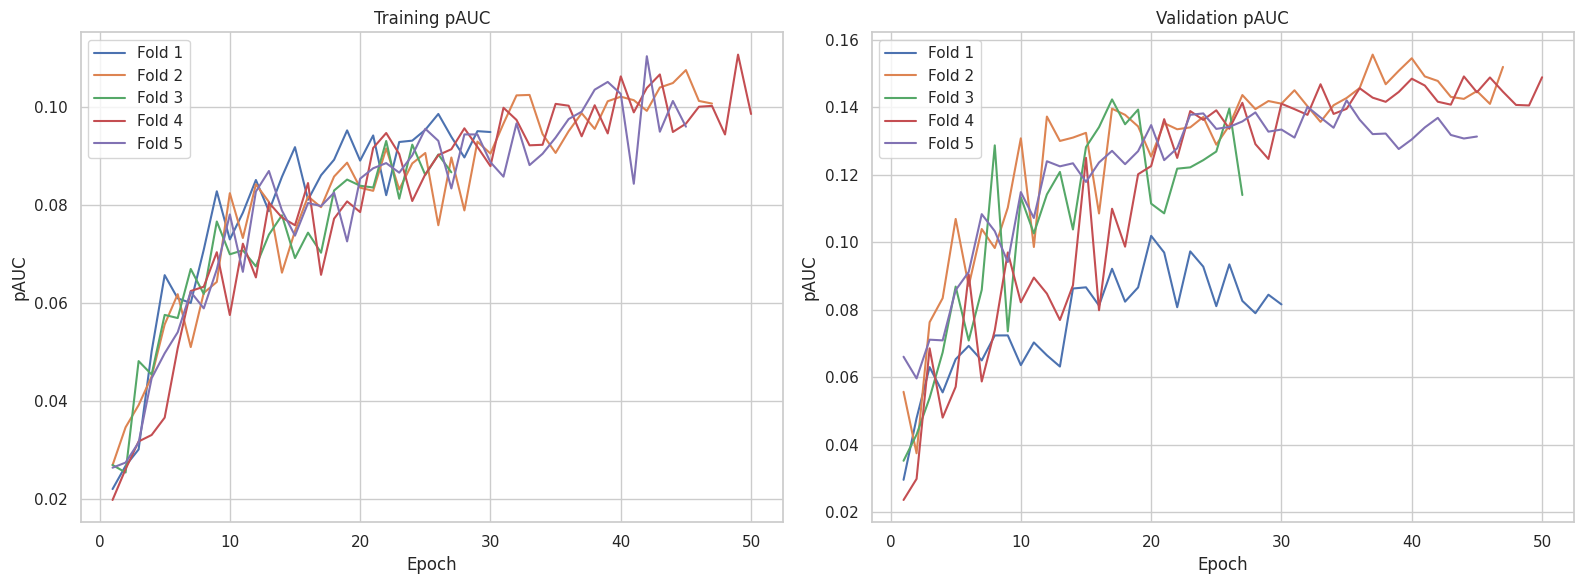

In [14]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(x='epoch', y='train_pauc', hue='Fold', data=histories, ax=axes[0])
axes[0].set_title('Training pAUC')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('pAUC')
axes[0].legend(loc='best')

sns.lineplot(x='epoch', y='val_pauc', hue='Fold', data=histories, ax=axes[1])
axes[1].set_title('Validation pAUC')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('pAUC')
axes[1].legend(loc='best')

fig.tight_layout()
plt.show()

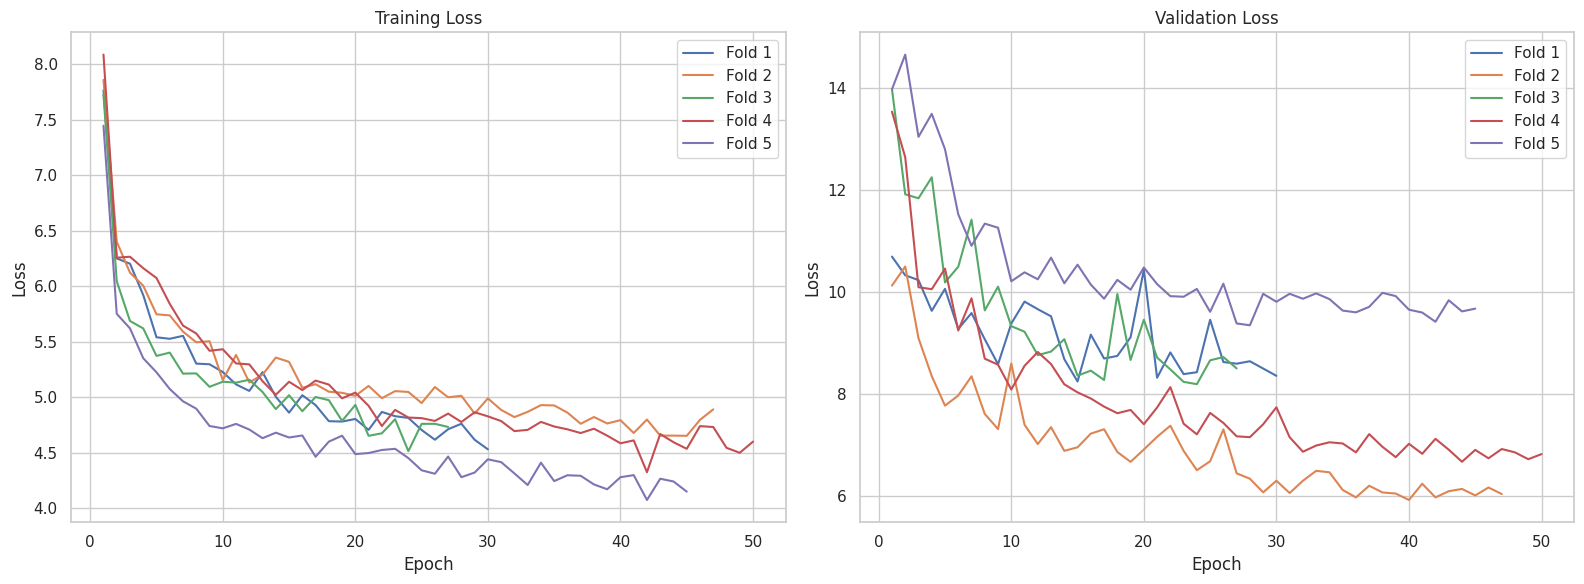

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(x='epoch', y='train_loss', hue='Fold', data=histories, ax=axes[0])
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(loc='best')

sns.lineplot(x='epoch', y='val_loss', hue='Fold', data=histories, ax=axes[1])
axes[1].set_title('Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='best')

fig.tight_layout()
plt.show()